In [107]:
from datetime import datetime, timedelta
from app.tasks.generation import generation as generation_task
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [157]:
# display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
# fix seed to make results reproducible
np.random.seed(7)

In [147]:
data = pd.read_csv('../data/generation_2017.csv').set_index('timestamp')

In [148]:
def split_train_test(ds, ratio=2/3):
    train_length = int(ratio * len(ds))
    return ds[:train_length], ds[train_length:]
    
def create_datasets(ds, lookback=1):
    """
    Create two datasets for training: X = input, Y = output.
    Y is just a time-shifted version of X. The lookback argument
    tells us how many samples to scan back.
    
    TODO: higher-dimensional inputs and outputs: look back at several points in time 
    and also forecast several points into the future.
    """
    acc_x, acc_y = [], []
    for i in range(len(ds) - lookback):
        acc_x.append(ds[i])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)

In [149]:
lookback = 3
model_df = pd.Series(list(zip(data.renewables, data.non_renewables)))
dataset = model_df.values
train_ds, test_ds = split_train_test(dataset)
train_x, train_y = create_datasets(train_ds, lookback)
test_x, test_y = create_datasets(test_ds, lookback)

In [150]:
model = Sequential()
model.add(Dense(8, input_dim=2, activation='relu'))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=20, batch_size=16, verbose=2)

Epoch 1/20
 - 2s - loss: 46994445.3761
Epoch 2/20
 - 1s - loss: 4164096.3458
Epoch 3/20
 - 1s - loss: 2235840.0473
Epoch 4/20
 - 1s - loss: 1887529.8802
Epoch 5/20
 - 1s - loss: 1799354.7226
Epoch 6/20
 - 1s - loss: 1781068.6986
Epoch 7/20
 - 1s - loss: 1777675.7702
Epoch 8/20
 - 1s - loss: 1778954.6430
Epoch 9/20
 - 1s - loss: 1781679.0300
Epoch 10/20
 - 1s - loss: 1780317.2953
Epoch 11/20
 - 1s - loss: 1781366.4682
Epoch 12/20
 - 1s - loss: 1781037.0306
Epoch 13/20
 - 1s - loss: 1779587.4373
Epoch 14/20
 - 1s - loss: 1782906.9757
Epoch 15/20
 - 1s - loss: 1783739.6217
Epoch 16/20
 - 1s - loss: 1783172.0749
Epoch 17/20
 - 1s - loss: 1781203.9170
Epoch 18/20
 - 1s - loss: 1778950.2727
Epoch 19/20
 - 1s - loss: 1778420.1683
Epoch 20/20
 - 1s - loss: 1778882.7088


In [151]:
train_score = model.evaluate(train_x, train_y, verbose=0)
print(f'Train Score: {train_score:.2} MSE ({math.sqrt(train_score):.2} RMSE)')
test_score = model.evaluate(test_x, test_y, verbose=0)
print(f'Test Score: {test_score:.2} MSE ({math.sqrt(test_score):.2} RMSE)')


Train Score: 1.8e+06 MSE (1.3e+03 RMSE)
Test Score: 1.4e+06 MSE (1.2e+03 RMSE)


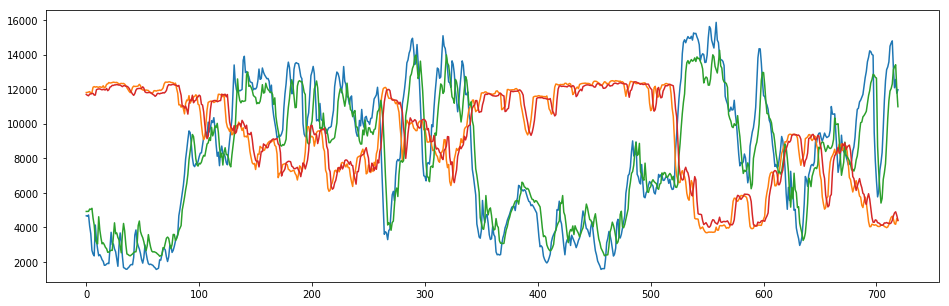

In [158]:
test_predict = model.predict(test_x)
plt.plot(model_df[-720:].apply(pd.Series).reset_index(drop=True))
plt.plot(test_predict[-720:])
plt.show()

It's evident that the model doesn't perform well with a three-hour horizon. It just predicts the input, more or less.

**TODO**: use a window 